In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geopy.distance import geodesic

from sklearn import linear_model, model_selection, metrics, preprocessing

## Load train and test data

In [2]:
# train set
df_mess_train = pd.read_csv('mess_train_list.csv')

# test set
df_mess_test = pd.read_csv('mess_test_list.csv')

# position associated to train set
pos_train = pd.read_csv('pos_train_list.csv') 

In [3]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [4]:
print(df_mess_train.shape)
df_mess_train.describe()

(39250, 8)


,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [5]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [6]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


## Prepare data

In [7]:
# determine all Base stations that received at least 1 message
trainBs  = np.unique(df_mess_train['bsid'])
testBs   = np.unique(df_mess_test['bsid'])
listOfBs = np.union1d(trainBs, testBs) 
testOnlyBs = np.lib.arraysetops.setdiff1d(testBs, trainBs)

print(f"Number of stations: %d, test only %d" % (len(listOfBs), len(testOnlyBs)))

Number of stations: 259, test only 8


In [8]:
df_mess_train['did'].unique().shape

(113,)

In [9]:
def tan_degree(x):
    """ Tangent for degree values (latitude) """
    return np.tan(x * np.pi / 180)

def arctan_degree(x):
    """ arc tan to degree """
    return np.arctan(x) * 180 / np.pi

def deg_to_complex(x):
    """ Degree angle to corresponding complex """
    xx = x * np.pi / 180
    return np.cos(xx), np.sin(xx)

def complex_to_deg(z):
    """ Complex to degree angle """
    return np.angle(z[:,0] + 1j*z[:,1], deg=True)

In [10]:
def feat_mat_const(df, listOfBs, keepMax=2):
    """ Feature Matrix construction, 
        Return a two-way table with BS on horizontal axis
        Keep at most keepMax BS per message
    """
    
    # Keep at max keepMax base-stations per message
    df = df.groupby('messid'). \
        apply(lambda x: x.sort_values(['rssi'], ascending=False)). \
        reset_index(drop=True).groupby('messid').head(3)
    
    # Add active column
    df['active'] = 1
    
    # Add tangent of latitude
    df['bs_tanlat'] = tan_degree(df['bs_lat'])
    
    r,i = deg_to_complex(df['bs_lng'])
    df['bs_coslng'] = r
    df['bs_sinlng'] = i
    
    # Add extra rows for Base-stations that are not present in this dataset
    usedBs = np.unique(df['bsid'])
    missingBs = np.lib.arraysetops.setdiff1d(listOfBs, usedBs)
    df2 = pd.DataFrame([['-1', bs, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] for bs in missingBs], columns=df.columns)
    df = df.append(df2)
    
    #df = df[df['bs_lat'] < 50]
    
    # Pivot BS to columns
    df = df.pivot_table(index='messid', 
                                    values=['active', 'nseq', 'rssi', 'bs_tanlat', 'bs_coslng', 'bs_sinlng'], 
                                    columns=['bsid'],
                                    fill_value=0)
    resDf = df.reorder_levels([1, 0], axis=1).sort_index(level=0, axis=1)
    return resDf.drop(['-1'])

In [11]:
def feat_mat_const2(df, listOfBs, keepMax=4):
    """ Feature Matrix construction """
    
    aggCols = ['pivot_lat', 'pivot_lng']
    for i in range(keepMax):
        bsCols =['bs%d_deltalat' % i, 'bs%d_deltalng' % i, 'bs%d_rssi' % i] #'bs%d_active' % i, 
        aggCols = aggCols + bsCols
        
    def aggregateBaseStations(groupBy):
        """ From a RSSI sorted DataFrameGroupBy
            create a dataframe with the 3 best BS 
        """
        bsSet = groupBy.iloc[:keepMax]
        # Barycentre
        w = bsSet['rssi'] / np.sum(bsSet['rssi'])
        lat = np.average(bsSet['bs_lat'], weights=w)
        lng = np.average(bsSet['bs_lng'], weights=w)
        bss = []
        for i in range(keepMax):
            if len(bsSet) > i:
                b = bsSet.iloc[0]
                bss.append([b['bs_lat'] - lat, b['bs_lng'] - lng, b['rssi']])
            else:
                bss.append([0, 0, -1e3])
        return pd.DataFrame(np.concatenate([[lat, lng], np.array(bss).ravel()]).reshape(1, -1), 
                            columns=aggCols)
            
    
    # Keep at max keepMax base-stations per message
    df = df.groupby('messid'). \
        apply(lambda x: x.sort_values(['rssi'], ascending=False)). \
        reset_index(drop=True).groupby('messid').apply(aggregateBaseStations)
    
    return df

In [12]:
def ground_truth_const(df_mess_train, pos_train):
    """ Ground truth construction """
    
    df = pd.concat([df_mess_train[['messid']], pos_train], axis=1)
    df_mean = df.groupby('messid').mean()

    return df_mean['lat'], df_mean['lng']

In [13]:
df_feat = feat_mat_const2(df_mess_train, listOfBs, 5)
df_feat.head()

,,pivot_lat,pivot_lng,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi
messid,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,39.647945,-104.953803,-0.030151,-0.001114,-121.500000,-0.030151,-0.001114,-121.500000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0
573bf3533e952e19126b256a,0,39.612745,-105.008827,0.000000,0.000000,-134.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0
573c0cd0f0fe6e735a699b93,0,39.753734,-105.005136,-0.021689,0.031485,-100.000000,-0.021689,0.031485,-100.000000,-0.021689,0.031485,-100.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0
573c1272f0fe6e735a6cb8bd,0,39.614550,-105.030671,0.090337,0.014279,-123.333333,0.090337,0.014279,-123.333333,0.090337,0.014279,-123.333333,0.090337,0.014279,-123.333333,0.000000,0.000000,-1000.0
573c8ea8864fce1a9a5fbf7a,0,39.765346,-105.034739,-0.010326,-0.008575,-98.000000,-0.010326,-0.008575,-98.000000,-0.010326,-0.008575,-98.000000,-0.010326,-0.008575,-98.000000,-0.010326,-0.008575,-98.0


In [14]:
df_feat.shape

(6068, 17)

In [15]:
df_mess_train.head(1)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917


In [16]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

## Make regressor and prediction using the train set

In [17]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test, trigo):
    
    """ train regressor and make prediction in the train set
      Input: df_feat: feature matrix used to train regressor
             ground_truth_lat: df_feat associated latitude
             ground_truth_lng: df_feat associated longitude
             df_test: data frame used for prediction
      Output: y_pred_lat, y_pred_lng
    """

    X_train = np.array(df_feat);
    reg = linear_model.LinearRegression()

    if trigo:
        ground_truth_tanlat = tan_degree(ground_truth_lat)
        ground_truth_lng_r, ground_truth_lng_i = deg_to_complex(ground_truth_lng)
        ground_truth = np.c_[ground_truth_tanlat, ground_truth_lng_r, ground_truth_lng_i]
        reg.fit(X_train, ground_truth);
        y_pred = reg.predict(df_test) 
        return arctan_degree(y_pred[:,0]), complex_to_deg(y_pred[:,1:]), reg

    else:
        ground_truth = np.c_[ground_truth_lat, ground_truth_lng]
        reg.fit(X_train, ground_truth);
        y_pred = reg.predict(df_test) 
        return y_pred[:,0], y_pred[:,1], reg

In [18]:
y_pred_lat, y_pred_lng, reg = regressor_and_predict(df_feat, 
                                        ground_truth_lat, ground_truth_lng, df_feat, False)

In [19]:
reg.coef_, reg.intercept_

(array([[ 5.34740772e-01, -3.59067521e-01,  3.56385517e-01,
         -2.39519640e-01,  2.75217411e-03,  3.56385517e-01,
         -2.39519640e-01, -7.40257457e-06, -2.78092516e-01,
          1.87291045e-01,  1.78224119e-05,  4.22471523e-01,
         -2.84022077e-01, -4.58181157e-05, -4.81348098e-01,
          3.23278946e-01,  1.97394604e-06],
        [-4.09442586e-01,  2.75937801e-01, -2.67914868e-01,
          1.80150596e-01, -2.06696031e-03, -2.67914868e-01,
          1.80150596e-01,  1.02727746e-05,  1.34751824e-01,
         -9.09606930e-02, -2.62849161e-05, -2.34570507e-01,
          1.57825024e-01,  4.98251230e-05,  2.22658616e-01,
         -1.49579754e-01, -1.72940661e-06]]),
 array([-18.92665127, -59.99362912]))

## Cross validation

In [20]:
def cross_val_fit_predict(df_feat, ground_truth_lat, ground_truth_lng, trigo):
    reg = linear_model.LinearRegression()
    
    if trigo:
        ground_truth_lng_r, ground_truth_lng_i = deg_to_complex(ground_truth_lng)
        ground_truth = np.c_[tan_degree(ground_truth_lat), ground_truth_lng_r, ground_truth_lng_i]

        y_pred = model_selection.cross_val_predict(reg, df_feat, ground_truth, cv=5)

        return arctan_degree(y_pred[:,0]), complex_to_deg(y_pred[:,1:]), reg

    else:
        ground_truth = np.c_[ground_truth_lat, ground_truth_lng]

        y_pred = model_selection.cross_val_predict(reg, df_feat, ground_truth, cv=5)

        return y_pred[:,0], y_pred[:,1]

In [21]:
#y_pred_lat, y_pred_lng = cross_val_fit_predict(df_feat, 
# ground_truth_lat, ground_truth_lng, True)

y_pred_lat, y_pred_lng = cross_val_fit_predict(df_feat, 
                                    ground_truth_lat, ground_truth_lng, False)

## Evaluate result

In [22]:
def vincenty_vec(vec_coord):
    """ Now using geodesic distance instead of Vincenty """
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] != 4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [geodesic(v[0:2], v[2:]).meters for v in vec_coord]

    return vin_vec_dist

In [23]:
# evaluate distance error for each predicted point
def eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

## Plot error distribution

In [24]:
def plotError(err_vec):
    
    err80 = np.percentile(err_vec, 80)
    
    print(f"error @ 80% = {err80:.1f} m")
    
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 

    plt.figure()
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0,
             label="Opt LLR", c='blue')

    # plot error @ 80%
    plt.axvline(x=err80/1000., ymin=0, ymax=100,
                linestyle='dashed', color='red')

    plt.xlabel('Distance Error (km)')
    plt.ylabel('Cum proba (%)')
    plt.axis([0, 30, 0, 100]) 

    plt.title('Error Cumulative Probability')
    plt.legend()

    plt.grid()

In [25]:
err_vec = eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)

error @ 80% = 8888.0 m


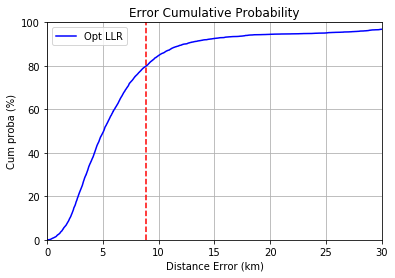

In [26]:
plotError(err_vec)

### Analysis

##### Mean square error

In [27]:
metrics.mean_squared_error(ground_truth_lat, y_pred_lat), \
metrics.mean_squared_error(ground_truth_lng, y_pred_lng)

(0.03944206657904257, 0.023753312890623837)

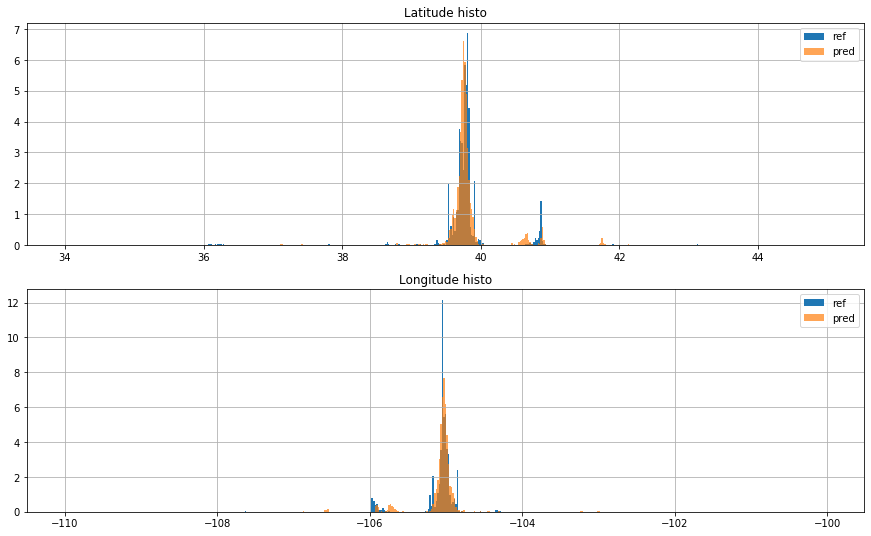

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(15, 9))
latBins = np.arange(34, 45, 0.02) #range(-91, 92)
axes[0].hist(ground_truth_lat, label='ref', bins=latBins, density=True)
axes[0].hist(y_pred_lat, label='pred', alpha=0.7, bins=latBins, density=True)
axes[0].set_title('Latitude histo')
axes[0].legend()
axes[0].grid()
lngBins = np.arange(-110, -100, 0.02) #range(-181, 182)
axes[1].hist(ground_truth_lng, label='ref', bins=lngBins, density=True)
axes[1].hist(y_pred_lng, label='pred', alpha=0.7, bins=lngBins, density=True)
axes[1].set_title('Longitude histo')
axes[1].legend()
axes[1].grid()

## Study implausible outliers

May happened when regressing on latitude and longitude angles:
- Latitude lower than -90 degrees or greater than 90 degrees
- Longitude lower than -180 degrees or greater than 180 degrees (which is an indicator more than an issue since we could wrap these longitudes)

In [29]:
(y_pred_lat < -85).sum(), (y_pred_lng < -180).sum(), (y_pred_lat > 85).sum(), (y_pred_lng > 180).sum()

(0, 0, 0, 0)

In [30]:
plausible_lat = (y_pred_lat > -80) & (y_pred_lat < 80)
has_implausible_lat = (plausible_lat.sum() != len(plausible_lat))
(plausible_lat.mean(),
metrics.mean_squared_error(ground_truth_lat[plausible_lat], y_pred_lat[plausible_lat]))

(1.0, 0.03944206657904257)

In [31]:
if has_implausible_lat:
    plt.scatter(ground_truth_lng[~plausible_lat], ground_truth_lat[~plausible_lat])
    plt.scatter(y_pred_lng[~plausible_lat], y_pred_lat[~plausible_lat])

In [32]:
if has_implausible_lat:
    firstInplausible = list(plausible_lat).index(False)
    firstInplausible, y_pred_lat[firstInplausible], y_pred_lng[firstInplausible]

In [33]:
if has_implausible_lat:
    df4 = df_feat.iloc[firstInplausible]
    firstImplausibleMessid = df4.name
    df4 = df4.unstack()
    df4[df4['active'] == 1]

In [34]:
plausible_lng = (y_pred_lng > -180) & (y_pred_lng < 180)

(plausible_lng.mean(),
metrics.mean_squared_error(ground_truth_lng[plausible_lng], y_pred_lng[plausible_lng]) )

(1.0, 0.023753312890623837)

In [35]:
(plausible_lat ^ plausible_lng).sum(), (plausible_lat & plausible_lng).sum() # XOR

(0, 6068)

Outliers are the same on latitude and longitude

Let's compute the error without the outliers:

In [36]:
if has_implausible_lat:
    err_vec_plausible = eval_geoloc(ground_truth_lat[plausible_lat], ground_truth_lng[plausible_lat], 
                                y_pred_lat[plausible_lat], y_pred_lng[plausible_lat])
    plotError(err_vec_plausible)

# Deep neural Network

In [37]:
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, backend, regularizers
import tensorview as tv
import tensorflow as tf

In [38]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df_feat.values, 
                                                                np.c_[ground_truth_lat.values, ground_truth_lng.values], 
                                                                test_size=0.1)

Normalize data to get proper network optimization

In [39]:
scaleX = preprocessing.StandardScaler()
scaleX.fit(xtrain)
xtrain = scaleX.transform(xtrain)
xtest = scaleX.transform(xtest)

scaleY = preprocessing.StandardScaler()
scaleY.fit(ytrain)
ytrain = scaleY.transform(ytrain)
# NO ytest = scaleY.transform(ytest)

In [40]:
metricNames = ['Loss']

In [62]:
model1 = models.Sequential([
    layers.Dense(64, name='dense_1', activation=activations.relu, input_shape=[df_feat.shape[1]]),
    layers.Dropout(0.01),
    layers.Dense(32, name='dense_2', activation=activations.relu),
    layers.Dropout(0.01),
    layers.Dense(2, name='dense_3', activation=activations.linear),
])

model1.compile(optimizer='adam',
          loss=losses.MeanSquaredError())
    
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1152      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 3,298
Trainable params: 3,298
Non-trainable params: 0
_________________________________________________________________


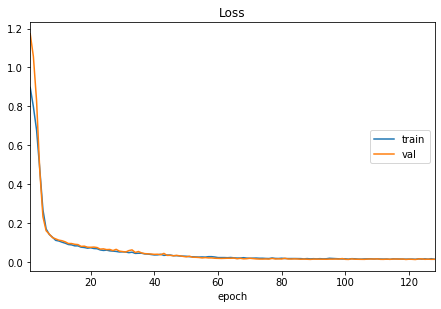

In [63]:
nEpochs = 128
batchSize = 64

tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=1)

history1 = model1.fit(xtrain, ytrain,
            epochs=nEpochs, batch_size=batchSize, 
            validation_split=0.1, 
            verbose=0,
            callbacks=[tvPlot]);

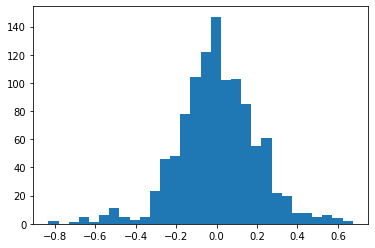

In [64]:
weights1 = model1.get_weights()
plt.hist(weights1[0].ravel(), bins=30);

In [65]:
yEst = model1.predict(xtest)
yEst = scaleY.inverse_transform(yEst)

In [66]:
metrics.mean_squared_error(ytest[:,0], yEst[:,0]), \
metrics.mean_squared_error(ytest[:,1], yEst[:,1])

(<tf.Tensor: id=93977, shape=(), dtype=float32, numpy=0.0017347102>,
 <tf.Tensor: id=93983, shape=(), dtype=float32, numpy=0.0013052664>)

error @ 80% = 5649.7 m


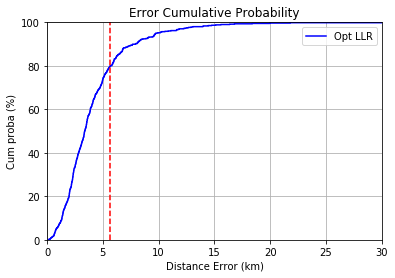

In [67]:
dnnErr_vec = eval_geoloc(ytest[:,0], ytest[:,1], yEst[:,0].reshape(-1), yEst[:,1].reshape(-1))
plotError(dnnErr_vec)

## Construct test prediction

In [47]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [48]:
df_feat_test = feat_mat_const2(df_mess_test, listOfBs)
df_feat.shape, df_feat_test.shape

((6068, 17), (5294, 14))

In [49]:
y_pred_test_lat, y_pred_test_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, 
                                                    ground_truth_lng, df_feat_test, False)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 17 is different from 14)

In [ ]:
test_res = pd.DataFrame(np.array([y_pred_test_lat, y_pred_test_lng]).T, columns = ['lat', 'lng'])
test_res = pd.concat([df_mess_test['messid'], test_res], axis=1)

In [ ]:
test_res.head()

In [ ]:
test_res.to_csv('pred_pos_test_list.csv', index=False)